# **Tutorial 4: Understanding Climatology - Precipitation**

> Indented block

> Indented block




**Week 1, Day 4, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** TBD

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, you will learn what is climatology and how to calculate climatology from satellite climate data.

By the end of this tutorial you will be able to:

* Understand the concept of climatology
* Calculate the climatology using long term satellite climate data
* Create meaningful maps including projection, coastlines, and other advanced features 


# **Setup**



In this section, we have:


1.   **Import cell:** imports all libraries you use in the tutorial.
2.   **Hidden Figure settings cell:** sets up the plotting style (copy exactly)
1.   **Hidden Plotting functions cell:** contains all functions used to create plots throughout the tutorial (so students don't waste time looking at boilerplate matplotlib but can here if they wish to). Please use only matplotlib for plotting for consistency.
2.   **Hidden Helper functions cell:** This should contain functions that students have previously used or that are very simple. Any helper functions that are being used for the first time and are important should be placed directly above the relevant text or exercise (see Section 1.1 for an example).
    



In [1]:
#google colan installs

# !pip install s3fs --quiet

# Properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [1]:
#Imports

import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import boto3
import botocore
import pooch


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# **Section 1: Access Monthly Precipitation Data**



In [3]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

In this tutorial, we will use the monthly precipitation climate data records data from NOAA to demonstrate how to calculate the long term climatology for climate analysis.

The data we are using is the [Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR)](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly). It provides monthly satellite-gauge and associated precipitation error estimates taken from January 1979–present on a 2.5°×2.5° grid. The CDR is created by combining the precipitation information from several satellite and in situ sources into a final merged product that uses the strengths of each data type to create a more accurate record.  

There is also a higher spatial resolution (1°×1°) at daily resolution for different applications. Due to computational concerns, we are only using the coarser resolution monthly data. You are encouraged to explore the use of the daily higher resolution data for your project.

## **Section 1.1: Access GPCP Monthly CDR data on AWS**

To perform analysis, we will need to access the monthly data files from AWS first. We will use the skills that we learned from last tutorial on accessing data from an AWS S3 bucket.

In [4]:
# Connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# Get the list of all data files in the AWS S3 bucket fit the data file pattern.
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

In [5]:
print("Total number of GPCP Monthly precipitation data files:")
print(len(file_location))

Total number of GPCP Monthly precipitation data files:
530


We have 530 GPCP monthly precipitation CDR data files in the AWS S3 buckect. Each data file contains the data of each month globally starting from January 1979. Now, let's open single data file to look at the data strcuture before we open all data files.

### ohad comment: the text said 528, I changed to 530. I think by the time the course runs it will be 532. maybe it's better to write, "more then 500"

In [7]:
# First, open a client connection
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

# Read single data file to understand the file structure
ds_single = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location[0],known_hash=None )) # open the file
# Check how many variables are inluded in one data file
ds_single.data_vars 


Data variables:
    lat_bounds    (latitude, nv) float32 ...
    lon_bounds    (longitude, nv) float32 ...
    time_bounds   (time, nv) datetime64[ns] ...
    precip        (time, latitude, longitude) float32 ...
    precip_error  (time, latitude, longitude) float32 ...

From the information provided by `xarray`, there is a total of five data variables in this monthly data file, including `precip` for the monthly precipitation and `precip_error` for the monthly precipitation error.


In [8]:
# Check the coordinates for the data file
ds_single.coords

Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01

All data is organised in three dimensions: `latitude`, `longitude`, and `time`. If we want to create a three-dimensional data array for the monthly precipitation data across the entire data period (from January 1979 until present).

In [19]:
# Open all the monthly data files and concatenate them along the time dimension.
# This process will take ~ 5 minute to complete due to the number of data files.

file_ob = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location]

SHA256 hash of downloaded file: da294c699f13c46a9f709efbc9eb06bcd8e780ae82b8753380a4d13528cfed94
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: aec3ecf6229e264b47afb6e028c9e46f210bab638985945c81b542a6e880646f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: f8f1a9903c1bd2ae43761c6abbeff805e214f4b8d9d0d8a1ed68d91c9447635c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ea5892fea7e002972685e50dac47933eefb015b5bf895c8c557534ddd2344617
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 0af5

SHA256 hash of downloaded file: 488fa83e1479f95eb8edeb5fedd09064f60247d3820dc1738b81ffc652ea3131
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: b2d2bba2a8c748ef42073824bf344f3b28d5f12bbd17178a15ccefab350dd444
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: b834476ef4b78679847920477486bdf4620213ad62b340d181a961a75a4a9730
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: b1e4ddd523be03a42f19c6004ac95d67fd774bca52e03e2b586fec953eedee7e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ed9d

SHA256 hash of downloaded file: ce8b748235e96e532abbd3867acdd230b607f87f0c4896791581861177c14e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ba137077d40e21702c037c8481f4b11fd30ecd97d8469f824d137ff341a92406
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: a9ee8f2b66510f01e20db0fc99a5b3bde03a9d48d0c01fd035001c46b4ab3d9c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: b381270f32e3bdbd374ec7f779ab0820379905f6343c715d3b09bac83b1502b7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 895a

SHA256 hash of downloaded file: 9bf199ac3accef0085873f46d6f36012b4d16ca53fb44dc51439e22d9d1ed589
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: f2bbd88fcc89dea097da5bb45ce257166a93647f40a6d13ea3d3d888d6d273a8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 37b3d8b8df26ac6aeea21353d2a678fc10b79bd28c1d0f55d588c20c3b3add86
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ab759f279d8251d38f41ac141bfcdd9a152cb7183b05ad381a77121dc0bc352a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: d571

SHA256 hash of downloaded file: 7e86bfabcc361e2c6472dd474da0e154e7a26e1ecd9f9a6f09e488652bc3fcd6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 58b598e26106f927db39c599fca212732df185dd03edc8c6e69243da9f34c7b7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 4ab4a16dd18f06c4d73a8afde3c3c23fa85b51157caf678e776cf426c6794b81
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 9a27188596926e890181226f95d614485089c19cd70ddbd063e9d439a3fcbc61
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 48f2

SHA256 hash of downloaded file: 479b822bac57ab6a9f9962e70eaf806982d63820af70c06be7f4913725e2f890
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: e75b836d084b0918f27bbf4e2523fa65806e7a17e56bc41569d35257684b8022
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 7f28f5c71361d63b1ab82d26a1bbc33d25048e64f62354e0377e33bcefdcd605
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 52c5f5b6ad6831b5bc0846740b719ede656bd779c15b978d55398b3709b16cff
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 6ee1

SHA256 hash of downloaded file: fbad7318053862848f36f691fb3ae1223ef22765f4f0119aeebce3125ce43829
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 7d3f1a3609e6b580ede1121bf3275cf0ff2aebfa01a2539bd39c1d7782ef2221
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 377473a9bdaf5e5c6a34093ffbff5f5947accfd3a75889656ec6949905651b32
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: fe571b7e37149fddea90a82f107c7b7eabbcb78f26ffc498c0a985d24e539c46
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 6a93

SHA256 hash of downloaded file: df47e3c4488a62028d8b89bd7acb4a5f8f1bcb07fd7878c949c68f55b9e9435e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 7af5ce9090db6ea5817c70bd0710a95016dcf09567f87304b13a1a0014e0d541
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 97c7f69debf51b31da76ba521039f4b871126bc3a8cfdff3fc55d453f295b696
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: f85a478b4dacaf7cadb7bec79c03d81a14b18638c1d84c927365d114094f2c53
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: bd9c

SHA256 hash of downloaded file: b8b0d21046e287164049b49b1027cca0667fce592ee1bda7d8d14aa1a74381cf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: dee6494fc36034e9c896c6a4b9f842f3db3001de6d640855e9959bec2c826904
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: c0c3a7d3389465737eb16921523ecefaab23d85e012e2d0eab5cf87cdc0fe186
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ac4d5d431bfe7a882f78c6d1d0854b9b0c05e15eea44edcb7346d66e69adf3ed
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ae12

SHA256 hash of downloaded file: eb0b202a107a2a436eaf02e77e2dd8e57270c1f45e57cfa8658298514653dbd8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 4ab80183a985013637f01cc488f6ebb422eef3afa79c8d151ea05aaf73e01e21
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 30aaee429f8d703ff96ad04813a32b0d73816574e499084d550792f401d3a7f8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 75d17204d5feff8ada1324fd96451ab6fae412f76a20a8179d4c412917fb695c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 0ba2

SHA256 hash of downloaded file: 39ad9ceaa48ef31f2565c1fa5157953fed0d2a53855f7924311d67fd83a22abc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 6e5b923e9d4b6e86846ed0961d9c0f172d8dcc18d1a9cdbe85fb8440352e7211
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: d90c467e20b901307fa71341efbe6d2d8c3f63b51a6862fe84499a379d07a361
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 77894b1a0986eeecc04d6773a6f5a5e9e5ebe8beee7f00604f71f61c2d98e0c3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: cf7e

SHA256 hash of downloaded file: 0f262972038465e4060826c2d8c23b74799ed0d279057500933f46fcc21f7817
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 7177b98db5ace3f2cfd69e0962836148bbedf1008c735fa3dcae6652b436a9e9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: dbb67bb13c7a0fc00b8240c286a83412ed053de3d0233ec32a8cd0f5032bcfe5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 7f4c9eb3325fdd05691e4e79c28a8b25f6ed292f76fe582951ec0bd5fc7ac012
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 3f4d

<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 530, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In [20]:
ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time')
ds

<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 530, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In the above code, we used `combine='nested', concat_dim='time'` to combine all monthly precipitation data into one data array along the dimension of `time`. This command is very useful when reading in multiple data files of same structure but for different parts of the full data record.

Since we are mostly interested in the precipitation data globally at this moment, let's extract the data array of precipitation from the entire dataset.

In [21]:
# Examine the precipitation data variable
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 530, latitude: 72, longitude: 144)>
dask.array<concatenate, shape=(530, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

As you can see, the data array has the dimension of `time` `longitude` `latitude`. Let's visualize the precipitation data to better understand it before further analysis.

## **Section 1.2: Visualize GPCP Data with Additional Map Features**

In previous tutorials, we learned how to make simple visualization using `matplotlib` using `latitude` and `longitude` as the y-axis and x-axis.

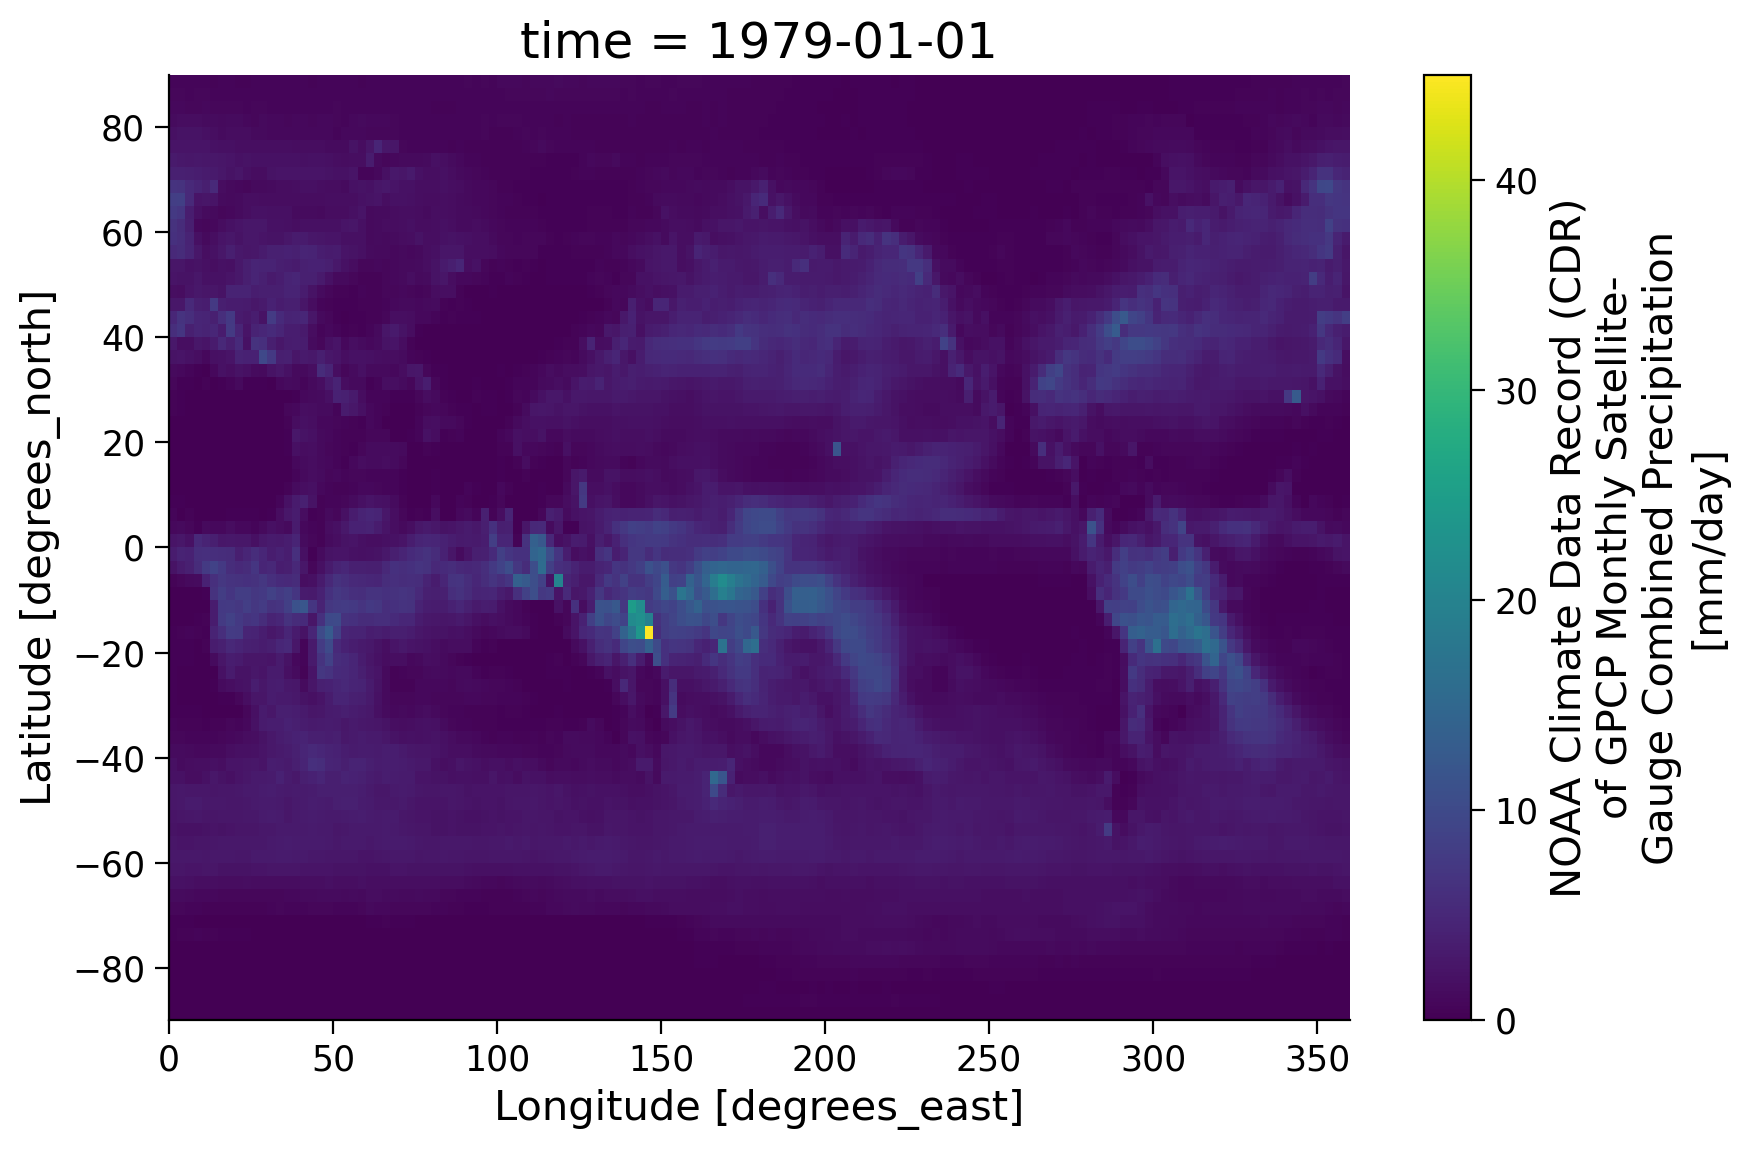

In [22]:
# Create simple map of the GPCP precipitation data using matplotlib
fig = plt.figure(figsize=(9,6))
# Use the first month of data as an example
precip.sel(time='1979-01-01').plot()

From the figure, you can vaguely see the boundary of land and ocean. Particularly for the North and South America. But this is not an ideal situation for visualize the data since we don't want to put any guess work in where we are looking at. So, we will now use `cartopy` to create the visualization with more advanced map features, such as, adding coastal lines, major grid marking, and creating maps with a specific projection for better science communication and climate applications.

In [23]:
# Visualize the precipitation data of a selected month using cartopy
# Select data for the month of interest
data = precip.sel(time='1979-01-01', method='nearest')
# Initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))
# Set base map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add major grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data with map projection transformation
# Also specify the maximum and minumum value show on the map to increase the
# contrast in the map.
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmin=0, vmax=20, cbar_kwargs=dict(shrink=0.5, label='GPCP Monthly Precipitation \n(mm/day)'))

The new map is much improved and gives us more information to better understand the GPCP monthly precipitation data. As we can see, Amazon rainforest, northern part of Australia, other tropical regions show higher amount of monthly precipitation during the month of January in 1979, which fits our basic knowledge of geography.

### **Exercise 1.2: How big is the error?**

Remember GPCP also offers a data variable that document the error of the estimated monthly precipitation data. The error information can be very helpful information for us to understand how confident should we be about for this data.

In this exercise, can you generate the precipitation error for the same month (1979-01-01) use the examples above?

In [24]:
################################################################################
# Exercise: create precipitation error map for the month of January 1979       #
#           using GPCP monthly data.                                           #
################################################################################

# Step 1: Select data for the month of interest using '.sel'
error = ...
# Step 2: Initate plot
fig = ...
# Step 3: Set map projection
ax = ...
# Step 4: Add coastal lines to indicate land/ocean
...
# Step 5: Add grid lines for latitude and longitute
...
# Step 6: Plot the precipitation error with a reasonable data range
...

Ellipsis

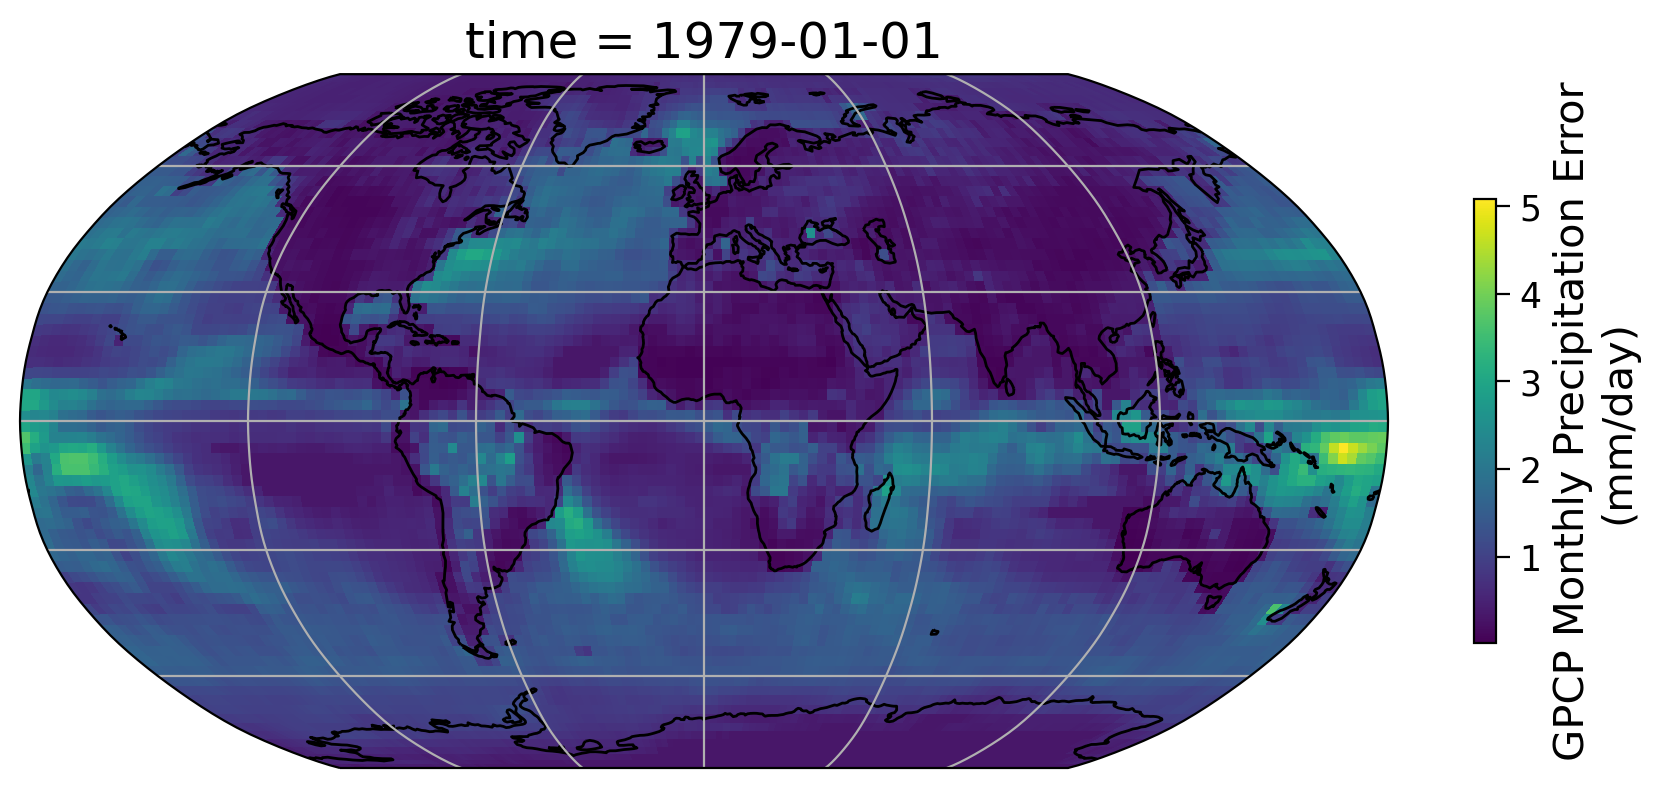

In [25]:
# to remove solution

# Select data for the month of interest
data = ds.precip_error.sel(time='1979-01-01', method='nearest')

# Initate plot
fig = plt.figure(figsize=(9,6))
# Set map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data for
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          cbar_kwargs=dict(shrink=0.4, label='GPCP Monthly Precipitation Error\n(mm/day)'))

Can you comment on the spatial pattern of the precipitation error provided by GPCP CDR data for this specific month?

In [26]:
# Please write about the error information based on the map above.
'''
Write you comments here
'''

'\nWrite you comments here\n'

## **Section 2: Climatology**

We have more than 40 years of monthly precipitation data. Let's take a look at a specific location about the entire time duration that we have the GPCP monthly data. Randomly, we are looking at the data point at (0°N, 0°E).

Text(0.5, 1.0, '')

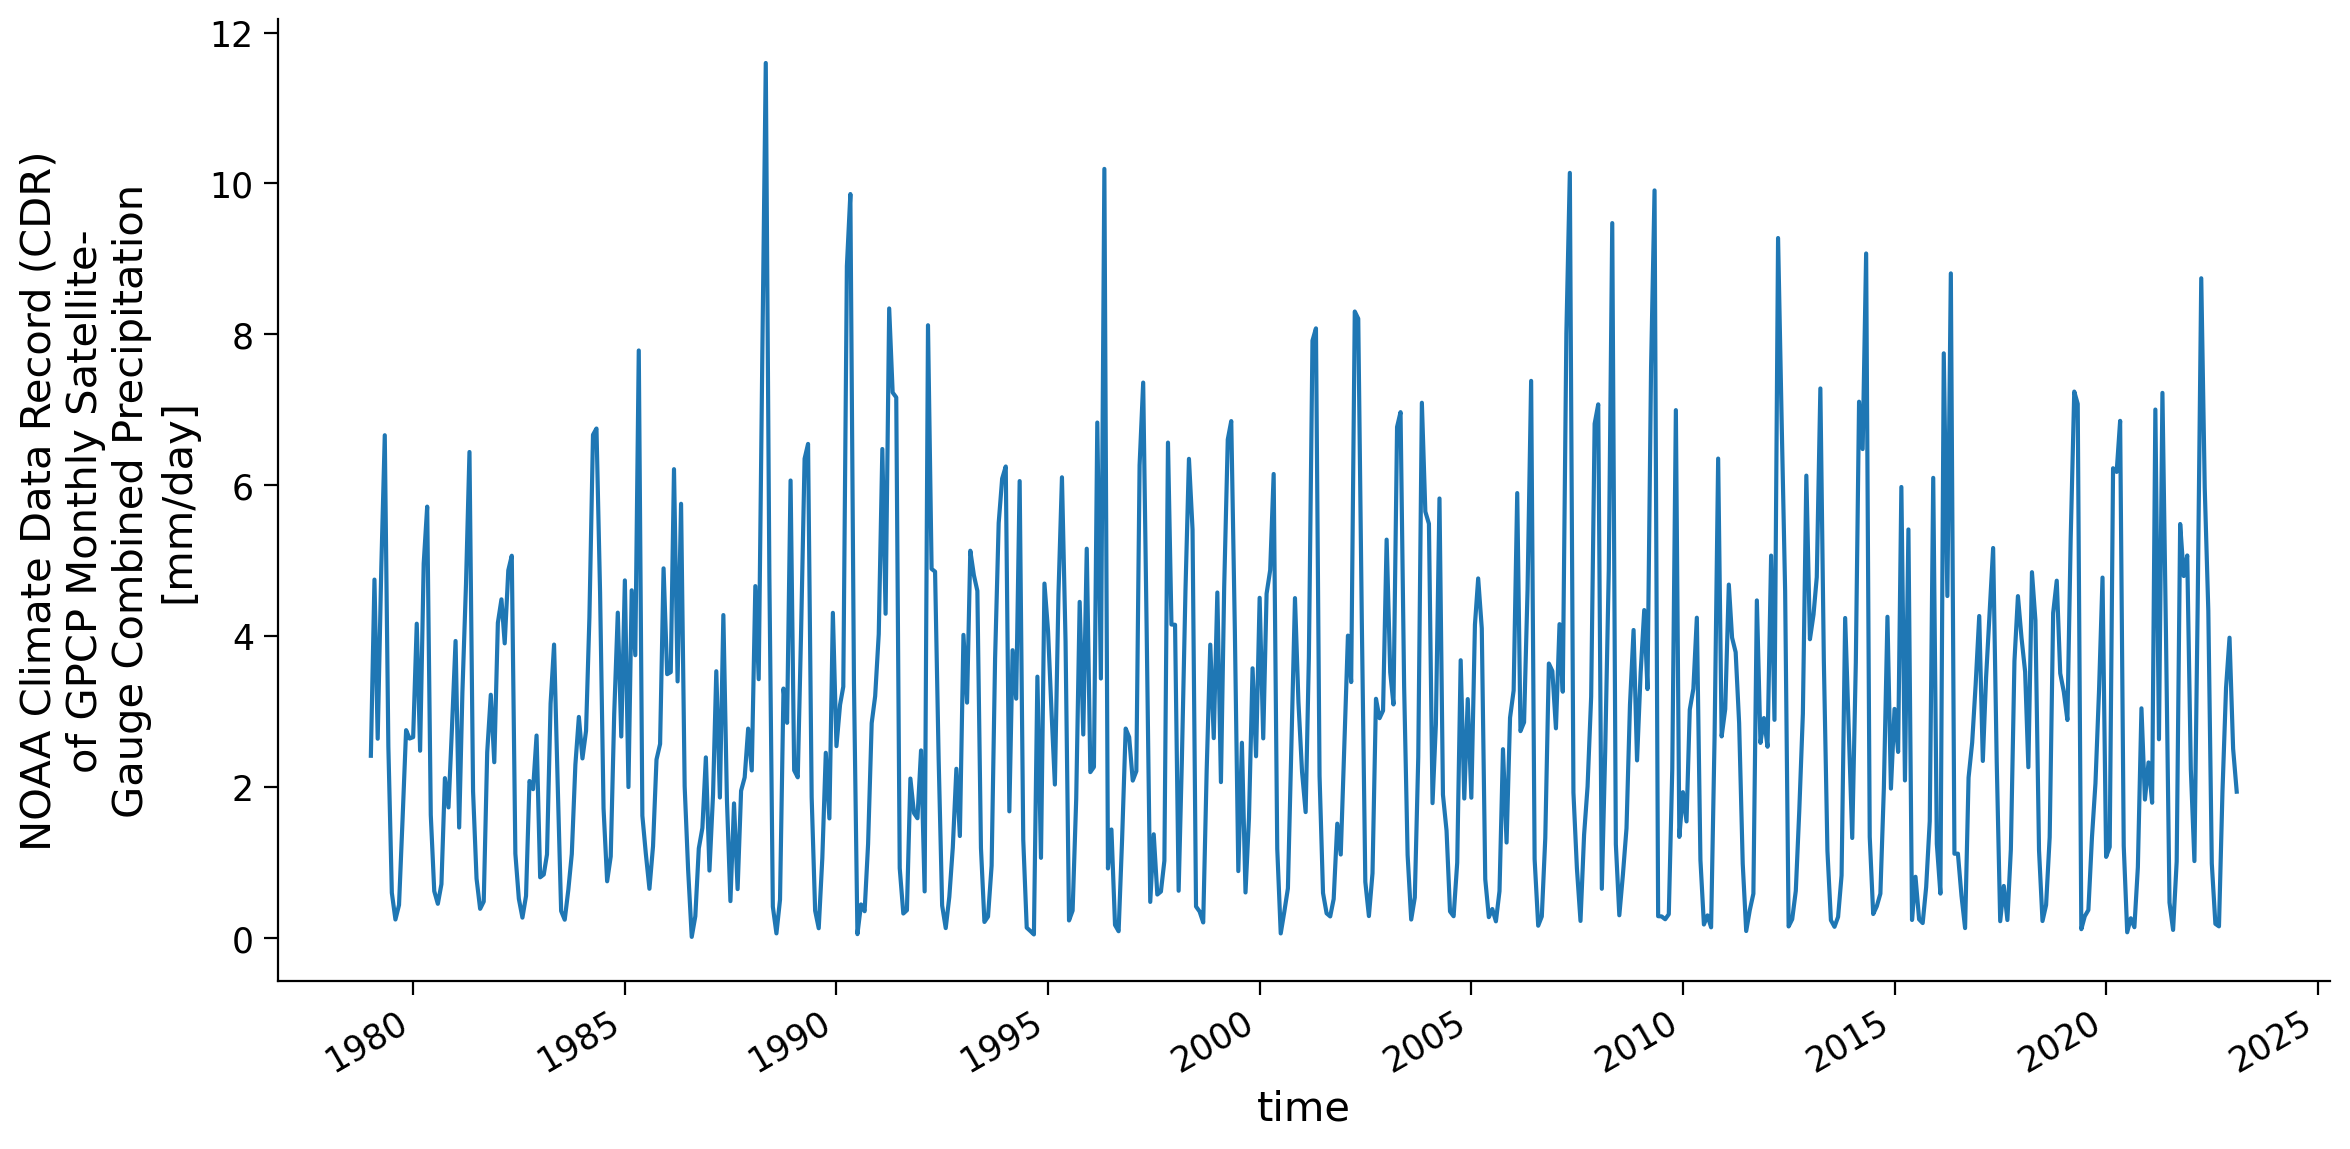

In [27]:
# select the entire time series for the grid that contains the location of (0N, 0E)
grid = ds.precip.sel(latitude=0, longitude=0, method='nearest')
# Initate plot
fig = plt.figure(figsize=(12,6))
grid.plot()
# Remove the automatically generated title
plt.title('')

From the time series plot, it looks like we have a repeating pattern with seasonal cycle. In previous tutorials, you have learned about how to calculate climatology. We can apply the same calculation to the precipitation CDR data to study the annual cycle of precipitation.

As a refresher, climatology often use a 30-year time period for calculation. Here let's use 1981-2010 as our reference period.

In [20]:
# First, let's extract the data for the time period that we want to use to
# calulate climatology (1981-2010)
precip_30yr = ds.precip.sel(time=slice('1981-01-01', '2010-12-30'))
precip_30yr

<xarray.DataArray 'precip' (time: 360, latitude: 72, longitude: 144)>
dask.array<getitem, shape=(360, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2010-12-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

We now have a defined time period 1981–2010 that we want to calculate climatology with. We can use `xarray` package's `groupby` functionality to easily calculate the monthly climatology.

`groupby` basically split the data based on a specific criteria (in this case, month of the year) and then perform the process (in our case, calculating mean value across 30 years for that specific month) to each group and recombine data together.

In [21]:
# Use groupby to calculate monthly climatology (1981-2010)
precip_clim = precip_30yr.groupby('time.month').mean(dim='time')
precip_clim

<xarray.DataArray 'precip' (month: 12, latitude: 72, longitude: 144)>
dask.array<transpose, shape=(12, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

With the resulting climatology data array, we can make a set of map to visualize the monthly climatology from four different seasons.

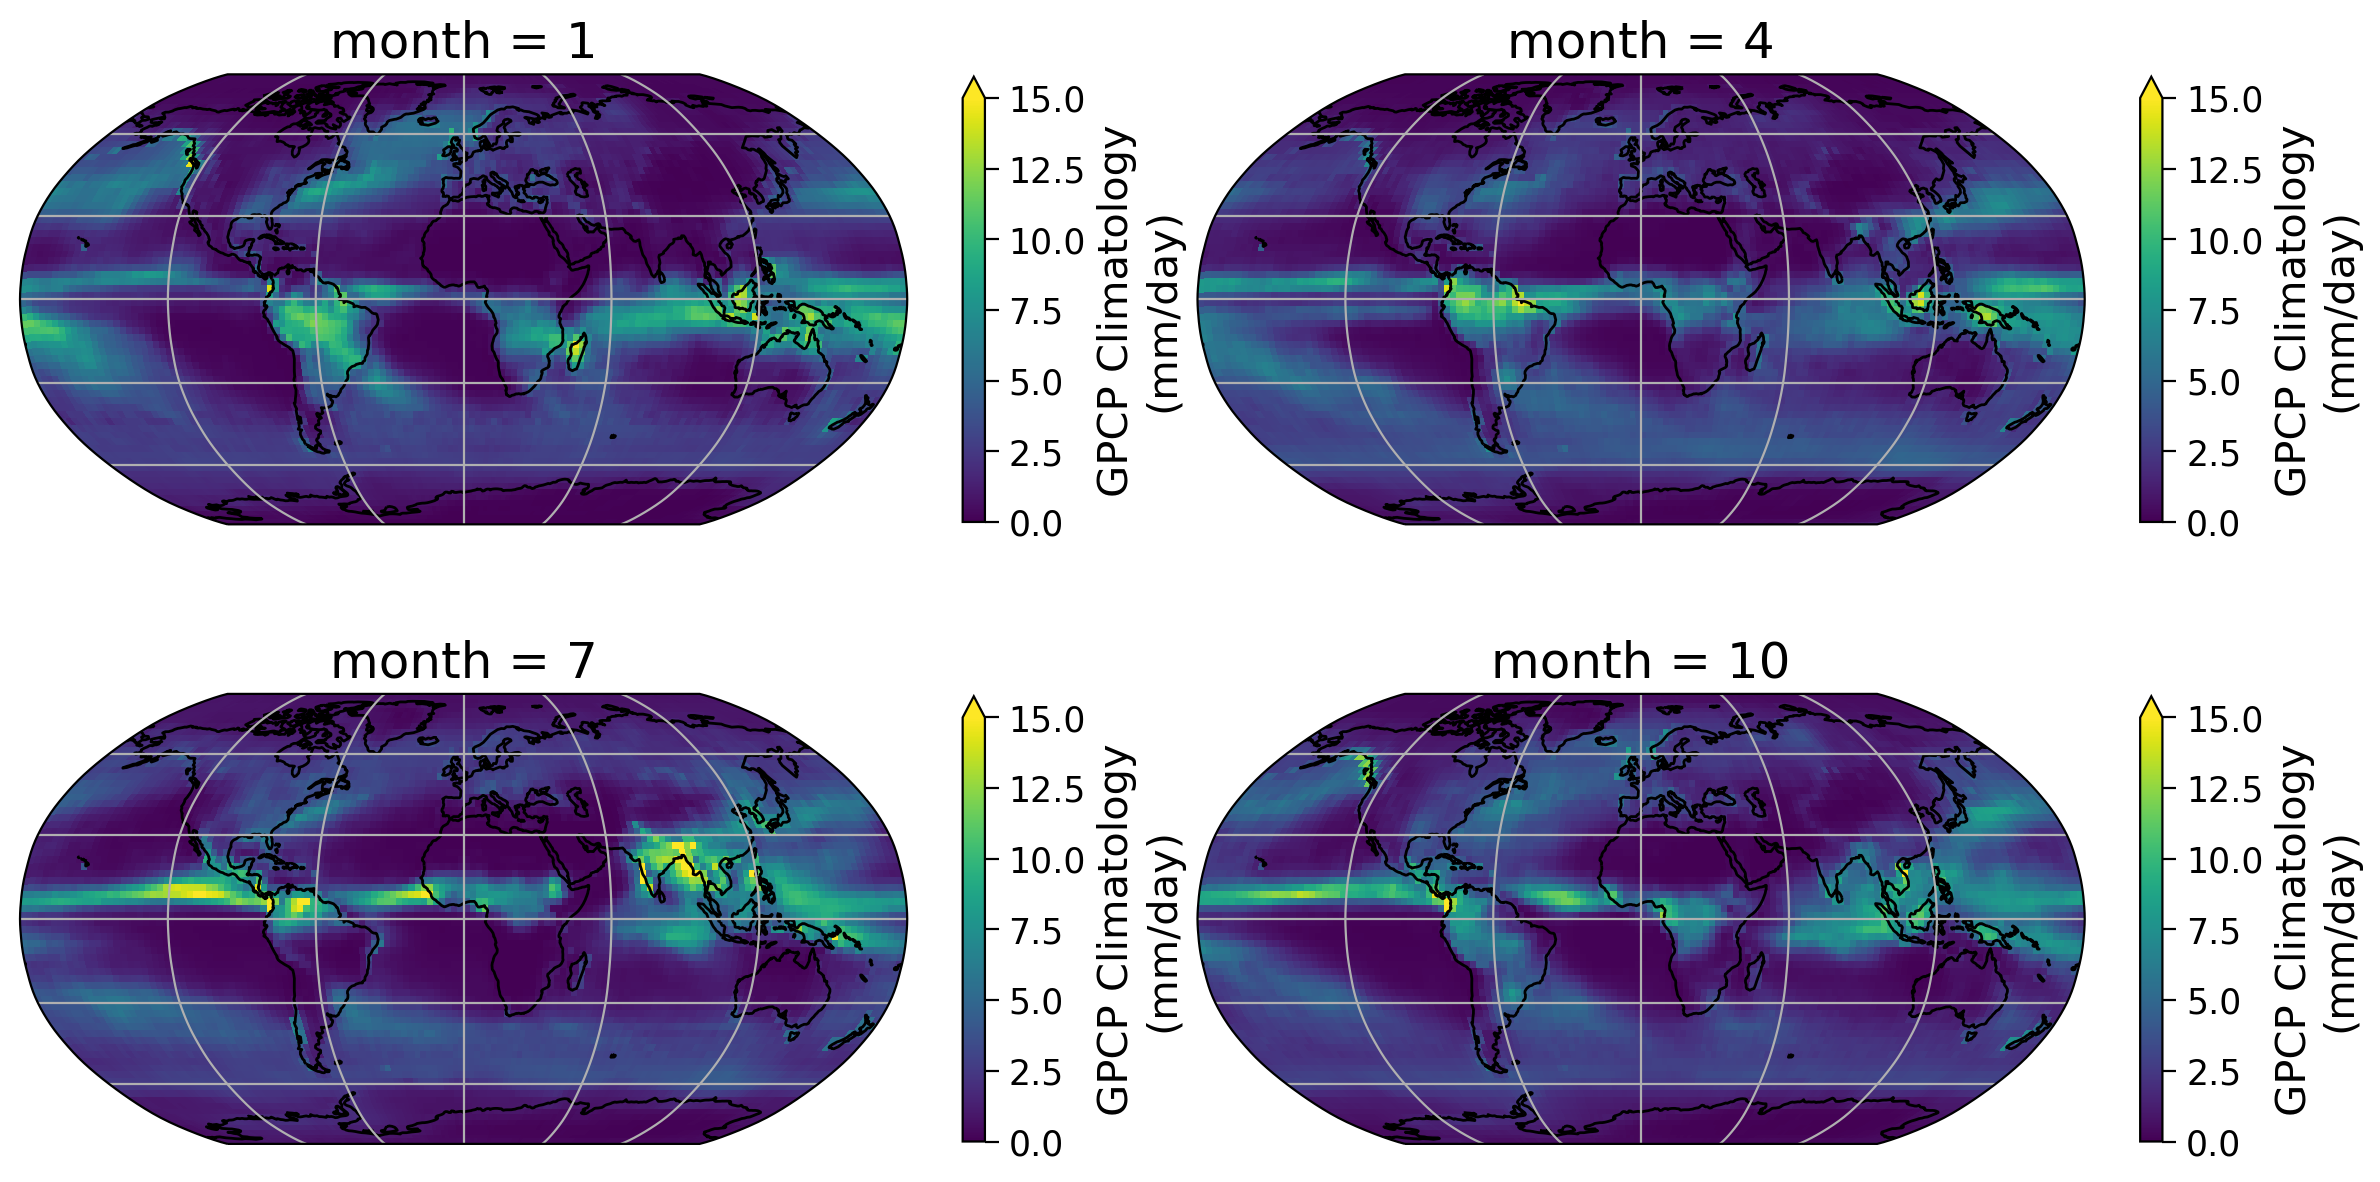

In [22]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # Draw the precipitation data
        precip_clim.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = 0, vmax = 15, # use the same range of max and min value
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology\n(mm/day)'))

In the seasonal collection of the climatology map, we can see a clear pattern of precipitation across the globe. The tropics show higher amount of precipitation comparing to other regions. You can also see the seasonal patterns of the precipitation change across different region of the globe (e.g., moonsoon imapcted areas).

Now let's look at the climatology of the point that we examined its entire time series earlier (i.e., (0°N, 0°E)).

Text(0.5, 1.0, '')

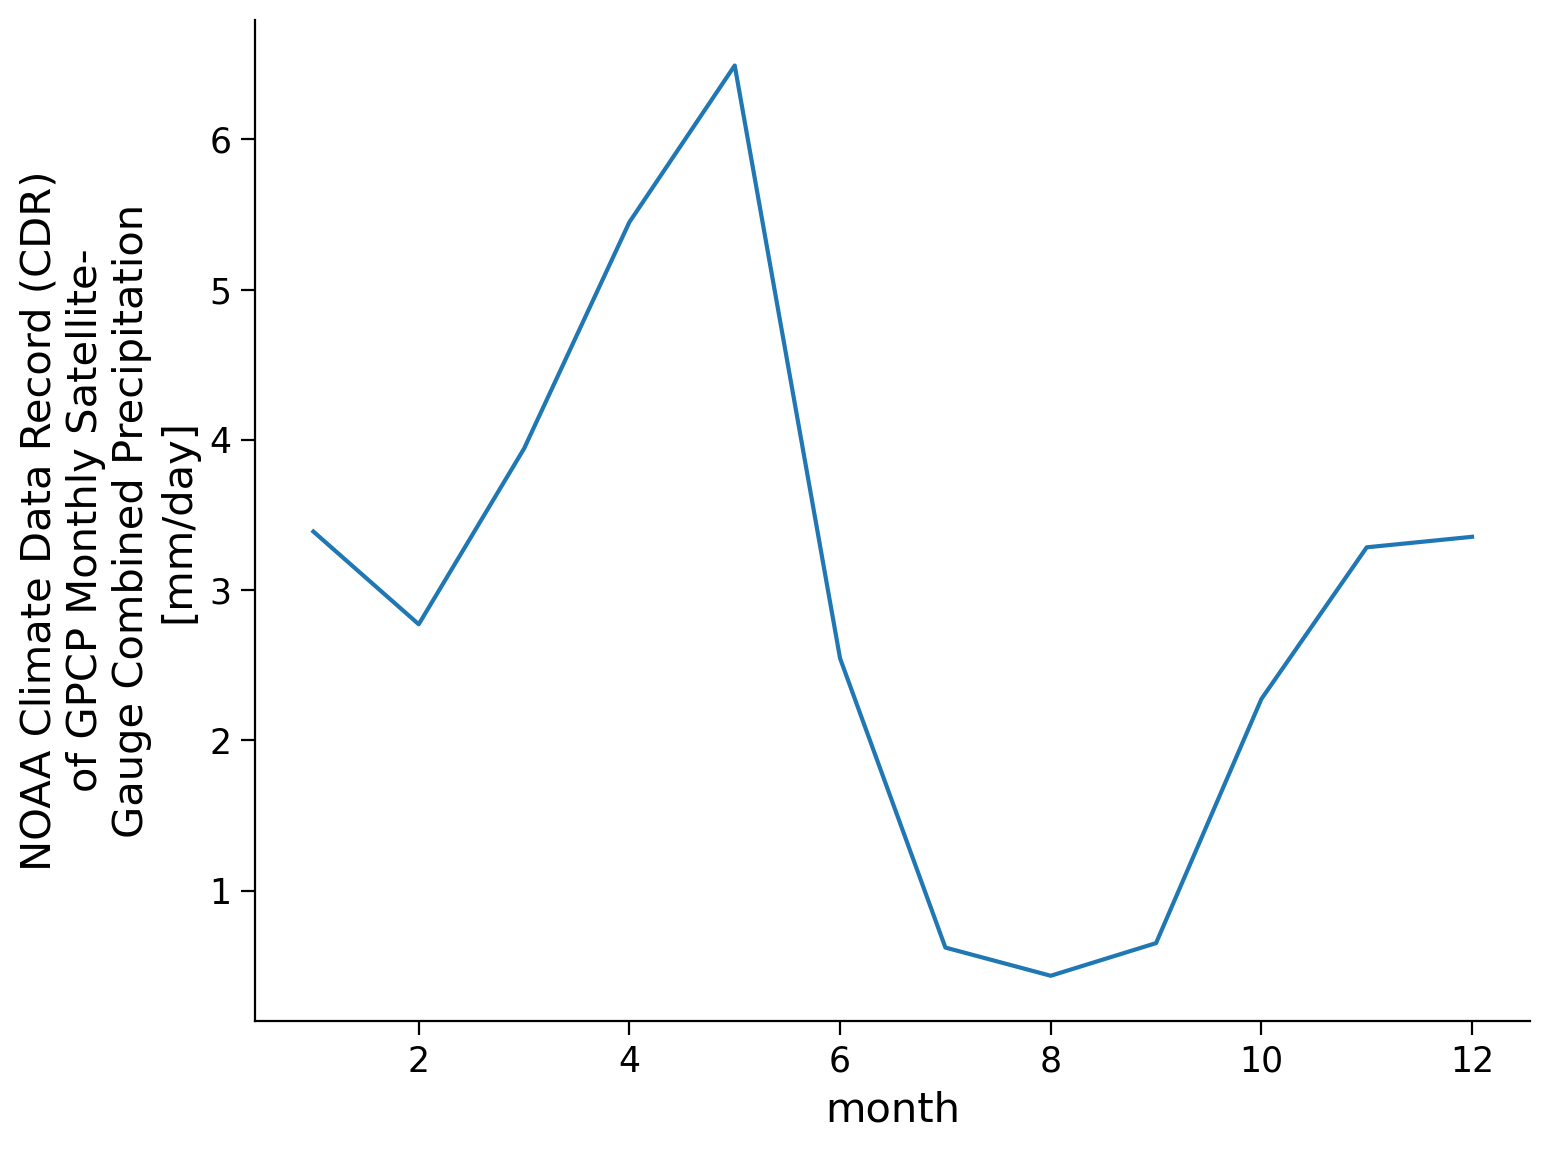

In [23]:
precip_clim.sel(latitude=0, longitude=0, method='nearest').plot()
# Remove the automatically generated title
plt.title('')

The monthly climatology time series for the point of interest demonstrate a notable seasonal pattern of dry and rainy months for the region with more precipitation between December and May while August is the driest of the year.

Climatology tells us about how the weather typically is like. When we compare the weather of a specific day/month against the climatology, we will know how much it is different from the climatology, or the norm. This will be the content for our next tutorial - anomaly!

### **Coding Exercise 2.1: Calculate Climatology Change**

As the climate change, the climatology may also change. In fact, climate researchers recalculate climatology every 10 years. This allow climate scientists to monitor how the norm of our climate system changes.

In this exercise, can you calculate the climatology of a different time period (1991-2020) and comparing it to the climatology that we just generated in this tutorail?

### Ohad suggetion: while the difference in years is interseting, the students don't really compare much. maybe it's more interseting to provide them a list of coordiantes and have them plot the different climatology in different places on earth? all in one graph. that will show them the spatial variablity. 

In [ ]:
################################################################################
# Exercise: Calculate precipitation climatology for 1991-2020 and comparing    #
#           the climatology with the 1981-2010.                                #
################################################################################

# Step 1: Extract 30 year data for 1991-2020

# Step 2: Calculate climatology for 1991-2020

# Step 3: Comparing the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October



'''

Please briefly describe the difference between two climatologies using GPCP
monthly data for two different

'''

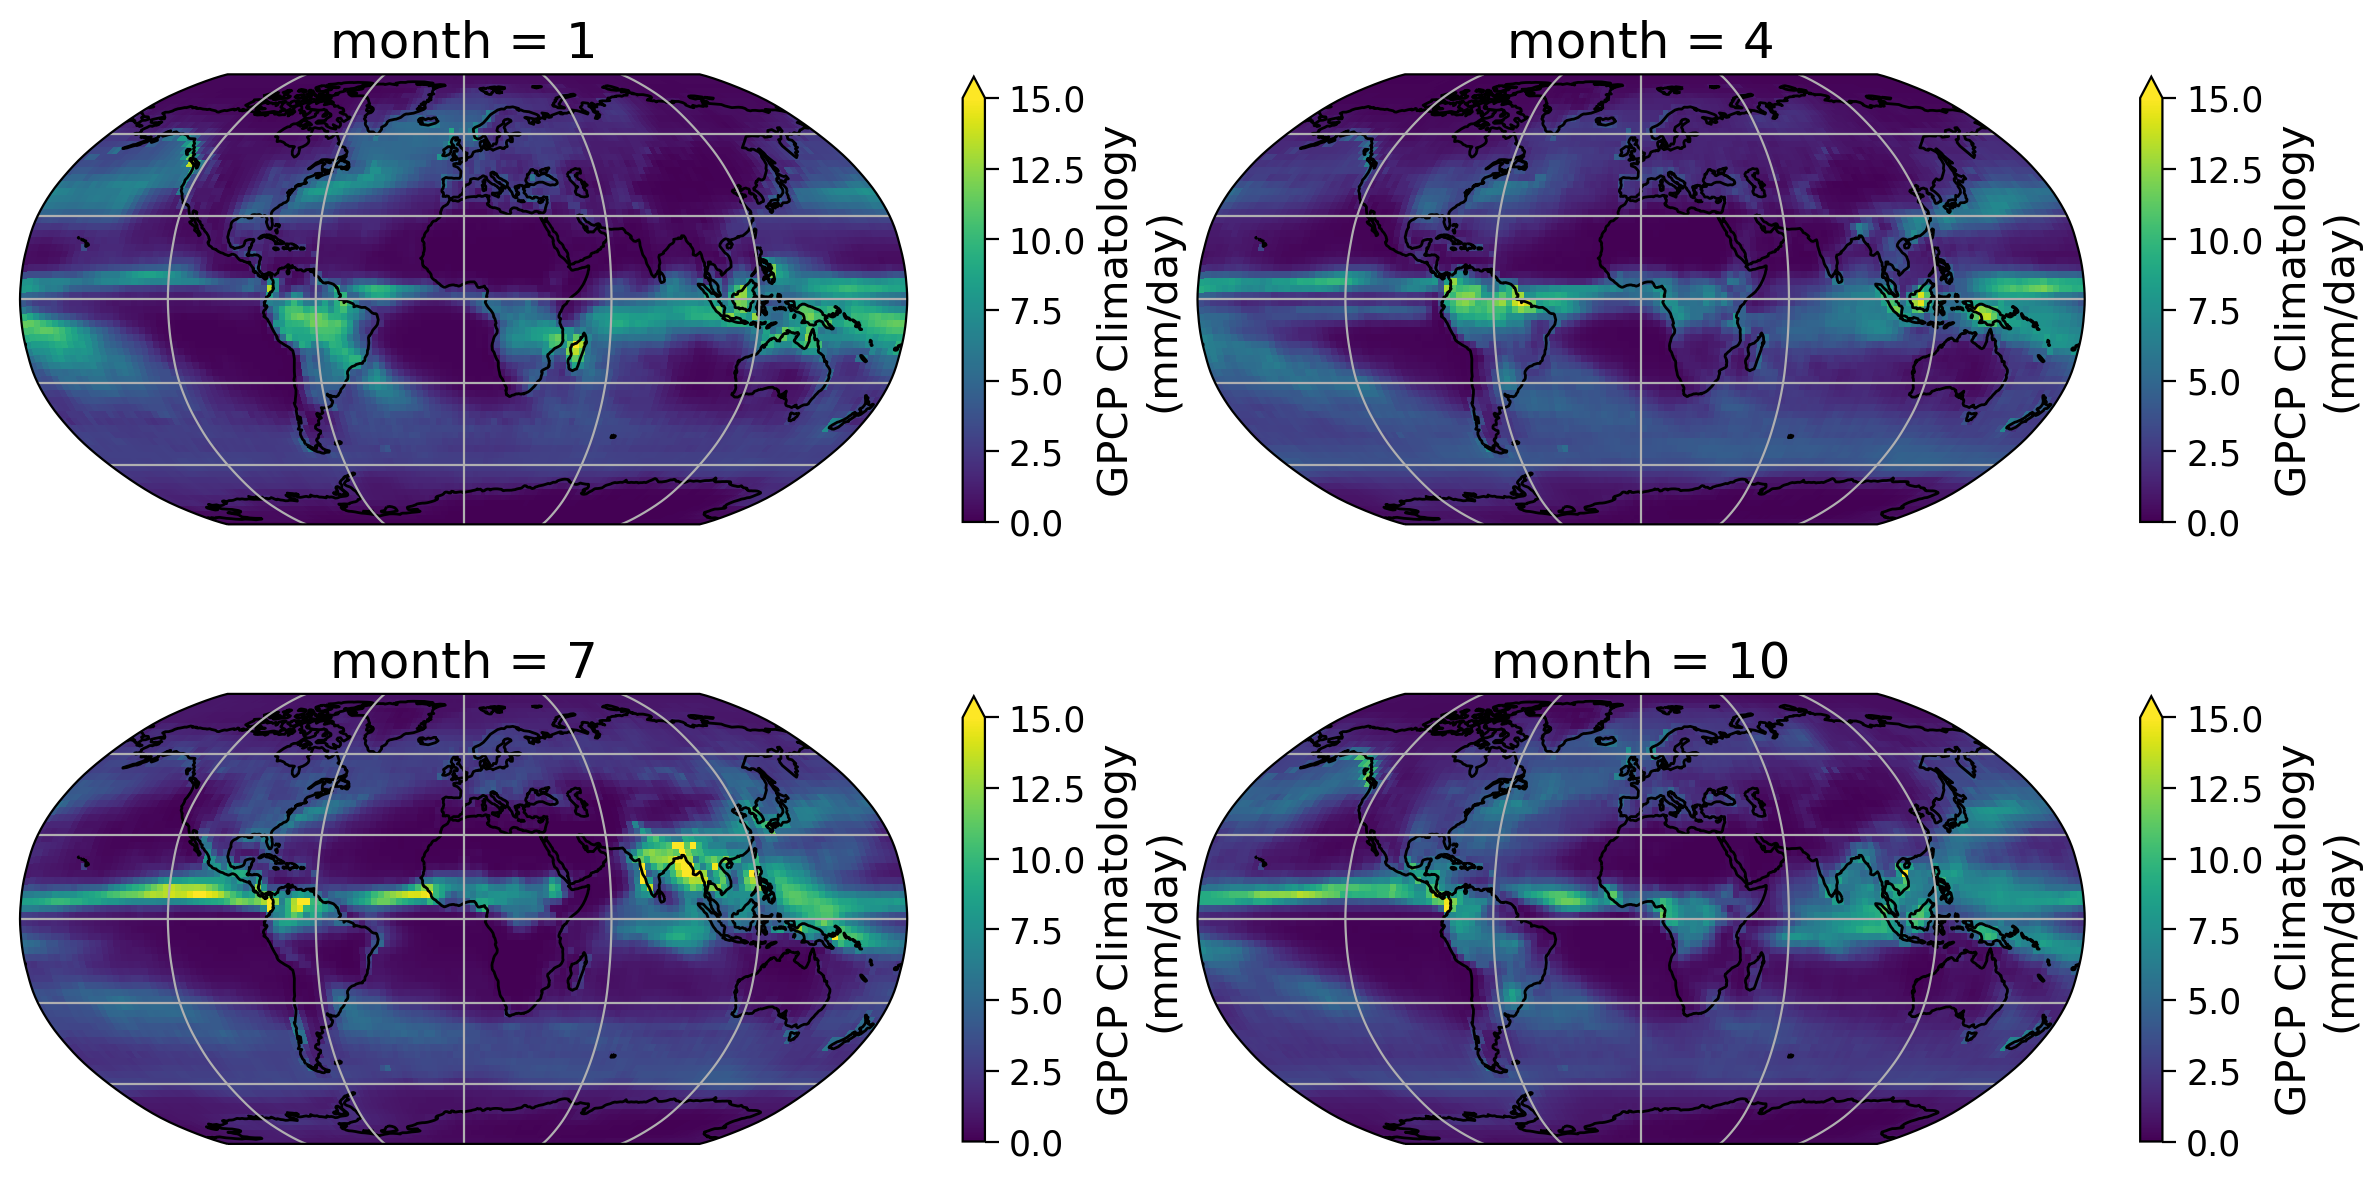

In [24]:
# to remove solution

################################################################################
# Exercise: Calculate precipitation climatology for 1991-2020 and comparing    #
#           the climatology with the 1981-2010.                                #
################################################################################

# Step 1: Extract 30 year data for 1991-2020
precip_30yr_exercise = ds.precip.sel(time=slice('1991-01-01', '2020-12-30'))

# Step 2: Calculate climatology for 1991-2020
precip_clim_exercise = precip_30yr_exercise.groupby('time.month').mean(dim='time')

# Step 3: Comparing the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # Draw the precipitation data
        precip_clim_exercise.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = 0, vmax = 15, # use the same range of max and min value
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology\n(mm/day)'))


# **Summary**

In this tutorial, we learned about what is climatology.

* Climatology often refers to the average state of the system (e.g., mean temperature, precipitation, etc) over a long period of time (typically 30 years).
* Satellite climate data records can be used to calculate climatology at global scale.

We will use the climatology skill learned from this tutorial in the next tutorial on anomaly.